In [7]:
import os
import glob

from lark import Lark, Tree, tree, Token
from IPython.display import Image, display

In [8]:
class Context:
    """
    Context class to store variables, functions, id_lst, param_lst, params, is_fc and is_fd.
    
    * `is_fc` is the flag to check if the function call is present.
    * `is_fd` is the flag to check if the function definition is present.
    """
    def __init__(self, vars=None, funs=None, id_lst=None, param_lst=None, params=None, is_fc=False, is_fd=False):
        self.vars = vars if vars is not None else {}
        self.funs = funs if funs is not None else {}
        self.id_lst = id_lst if id_lst is not None else []
        self.param_lst = param_lst if param_lst is not None else []
        self.params = params if params is not None else {}
        self.is_fc = is_fc
        self.is_fd = is_fd

def traverse_tree(node, context):
    if isinstance(node, Tree):
        return handle_tree_node(node, context)
    elif isinstance(node, Token):
        return handle_token_node(node, context)

def handle_tree_node(node, context):
    if node.data == "start":
        for c in node.children:
            traverse_tree(c, context)
    elif node.data in ["print_num", "print_bool"]:
        handle_print_statements(node, context)
    elif node.data in ["plus", "minus", "multiply", "divide", "modulus"]:
        return handle_arithmetic_operations(node, context)
    elif node.data in ["true", "false", "and_op", "or_op", "not_op"]:
        return handle_boolean_operations(node, context)
    elif node.data in ["if_exp", "test_exp", "then_exp", "else_exp"]:
        return handle_if_statements(node, context)
    elif node.data in ["equal", "smaller", "greater"]:
        return handle_comparison_operations(node, context)
    elif node.data == "def_stmt":
        handle_definition_statements(node, context)
    elif node.data == "variable":
        return traverse_tree(node.children[0], context)
    elif node.data == "fun_call":
        return handle_function_call(node, context)
    elif node.data in ["param", "fun_exp", "fun_ids", "fun_body", "fun_name"]:
        return handle_function_expressions(node, context)

def handle_token_node(node, context):
    try:
        return int(node.value)
    except:
        if context.is_fd:
            return node.value
        if context.is_fc and context.params is None:
            return node.value
        elif context.is_fc:
            return context.params.get(node.value, node.value)
        else:
            return context.vars.get(node.value, node.value)

def handle_print_statements(node, context):
    for c in node.children:
        if node.data == "print_num":
            print(traverse_tree(c, context))
        elif node.data == "print_bool":
            print("#t" if traverse_tree(c, context) else "#f")

def handle_arithmetic_operations(node, context):
    lst = [traverse_tree(c, context) for c in node.children]
    if any(type(ele) != int for ele in lst):
        raise TypeError("Type Error")
    
    if node.data == "plus":
        return sum(lst)
    elif node.data == "minus":
        return lst[0] - lst[1]
    elif node.data == "multiply":
        from functools import reduce
        from operator import mul
        return reduce(mul, lst)
    elif node.data == "divide":
        return lst[0] // lst[1]
    elif node.data == "modulus":
        return lst[0] % lst[1]

def handle_boolean_operations(node, context):
    if node.data == "true":
        return True
    elif node.data == "false":
        return False
    
    lst = [traverse_tree(c, context) for c in node.children]
    if any(type(ele) != bool for ele in lst):
        raise TypeError("Type Error")
    
    if node.data == "and_op":
        return all(lst)
    elif node.data == "or_op":
        return any(lst)
    elif node.data == "not_op":
        return not lst[0]

def handle_comparison_operations(node, context):
    lst = [traverse_tree(c, context) for c in node.children]
    if any(type(ele) != int for ele in lst):
        raise TypeError("Type Error")
    
    if node.data == "equal":
        return all(lst[0] == lst[i] for i in range(1, len(lst)))
    elif node.data == "smaller":
        return lst[0] < lst[1]
    elif node.data == "greater":
        return lst[0] > lst[1]

def handle_if_statements(node, context):
    if node.data == "if_exp":
        if traverse_tree(node.children[0], context):
            return traverse_tree(node.children[1], context)
        else:
            return traverse_tree(node.children[2], context)
    elif node.data in ["test_exp", "then_exp", "else_exp"]:
        return traverse_tree(node.children[0], context)

def handle_definition_statements(node, context):
    if isinstance(node.children[1], Tree) and node.children[1].data == "fun_exp":
        context.funs[traverse_tree(node.children[0], Context(context.vars, context.funs, is_fd=True))] = (
            traverse_tree(node.children[1], Context(context.vars, context.funs, is_fd=True))
        )
    else:
        context.vars[traverse_tree(node.children[0], context)] = traverse_tree(node.children[1], context)

def handle_function_call(node, context):
    param_lst = [traverse_tree(child, context) for child in node.children[1:]]
    if node.children[0].data == "fun_name":
        id_lst = traverse_tree(context.funs[traverse_tree(node.children[0], context)].children[0], Context(context.vars, context.funs, is_fd=True))
        params = {k: v for k, v in zip(id_lst, param_lst)}
        ans = traverse_tree(context.funs[traverse_tree(node.children[0], context)], Context(context.vars, context.funs, id_lst, param_lst, params, is_fc=True))
    else:
        id_lst = [traverse_tree(c, Context(context.vars, context.funs, is_fd=True)) for c in node.children[0].children[0].children]
        params = {k: v for k, v in zip(id_lst, param_lst)}
        ans = traverse_tree(node.children[0], Context(context.vars, context.funs, id_lst, param_lst, params, is_fc=True))
    return ans

def handle_function_expressions(node, context):
    if node.data == "param":
        return traverse_tree(node.children[0], context)
    elif node.data == "fun_exp":
        if context.is_fd:
            return node
        return traverse_tree(node.children[1], context)
    elif node.data == "fun_ids":
        return [traverse_tree(c, context) for c in node.children]
    elif node.data == "fun_body":
        return traverse_tree(node.children[0], context)
    elif node.data == "fun_name":
        return traverse_tree(node.children[0], context)

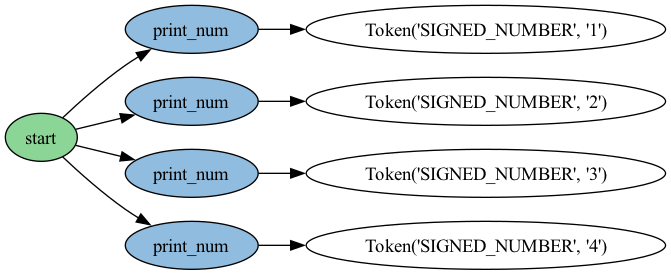

1
2
3
4


In [9]:
parser = Lark(open('grammar.lark'), parser='lalr')
with open("public_test_data/02_1.lsp") as f:
    try:
        code = f.read()
        parser_tree = parser.parse(code)
        tree.pydot__tree_to_png(parser_tree, "assets/02_1.png")
        display(Image("assets/02_1.png"))
        traverse_tree(parser_tree, Context())
    except TypeError as e:
        print(e)
    except:
        print("syntax error")

In [10]:
def collect_test_case_paths(path):
    paths = glob.glob(path)
    paths.sort()
    return paths

In [11]:
def run_test_case(path, show_tree=False):
    parser = Lark(open('grammar.lark'), parser='lalr')
    with open(path) as f:
        try:
            code = f.read()
            print(f"file: {path}")
            print("--------------------------------")
            
            
            parser_tree = parser.parse(code)
            traverse_tree(parser_tree, Context())
            if show_tree:
                save_name = os.path.basename(path).split(".")[0]
                tree.pydot__tree_to_png(parser_tree, f"assets/{save_name}.png")
                display(Image(f"assets/{save_name}.png"))
        except TypeError as e:
            print(e)
        except:
            print("Syntax Error")
    print("--------------------------------\n")

file: public_test_data/01_1.lsp
--------------------------------
Syntax Error
--------------------------------

file: public_test_data/01_2.lsp
--------------------------------
Syntax Error
--------------------------------

file: public_test_data/02_1.lsp
--------------------------------
1
2
3
4


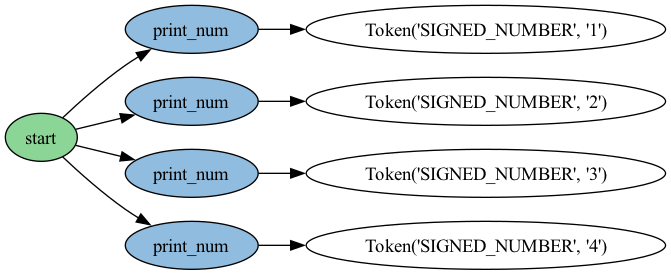

--------------------------------

file: public_test_data/02_2.lsp
--------------------------------
0
-123
456


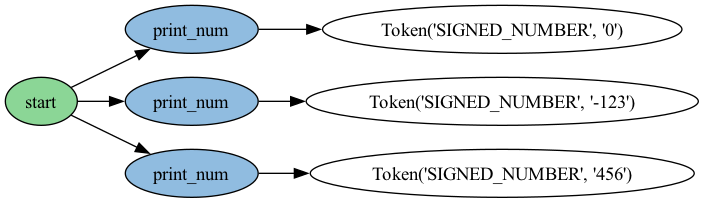

--------------------------------

file: public_test_data/03_1.lsp
--------------------------------
133
2
-1
-256


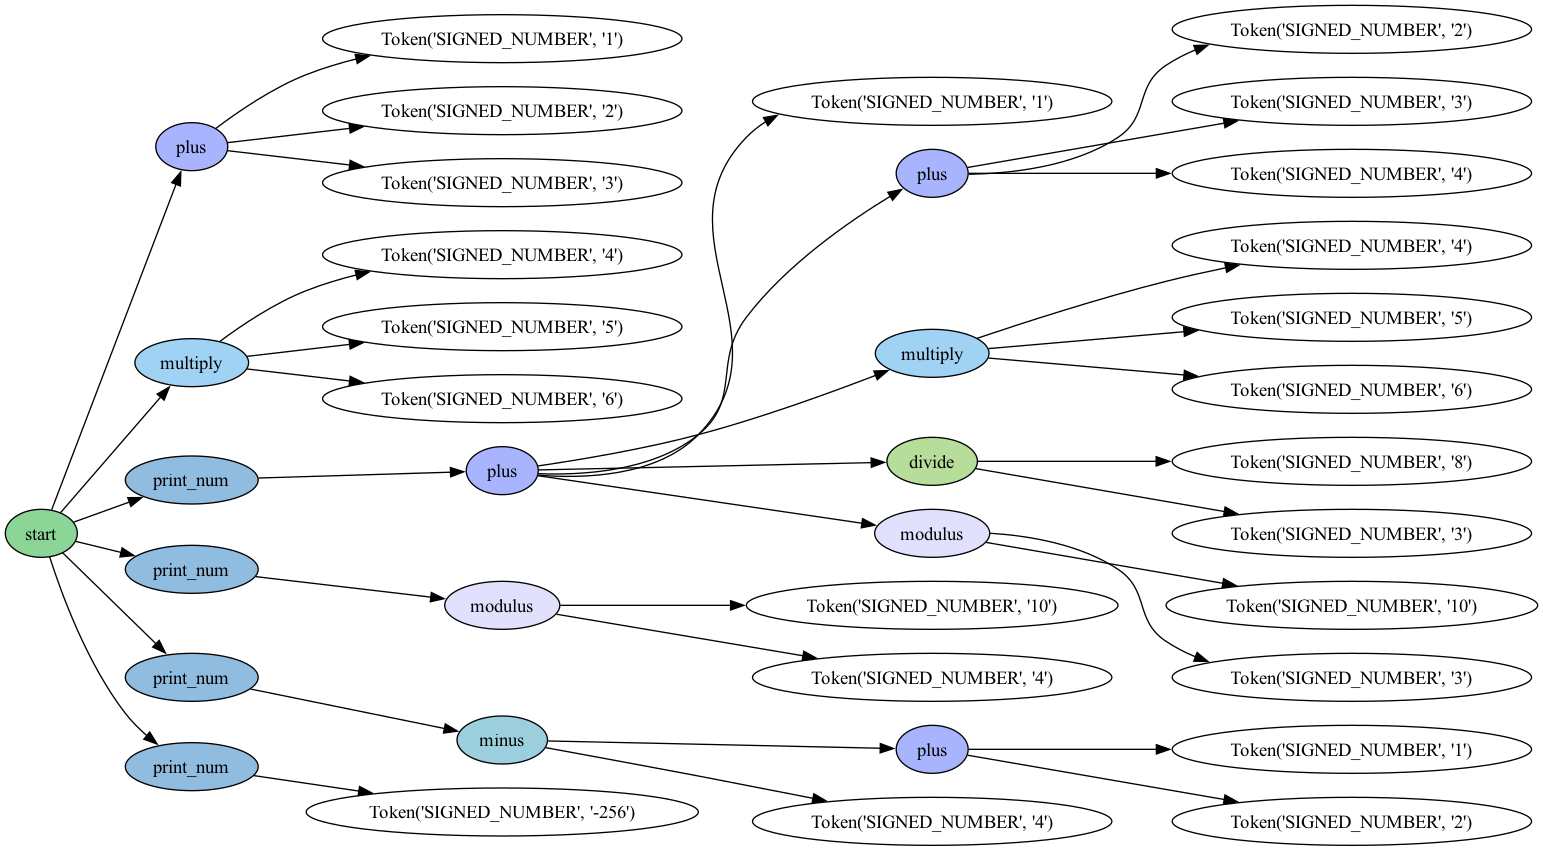

--------------------------------

file: public_test_data/03_2.lsp
--------------------------------
1
0
9


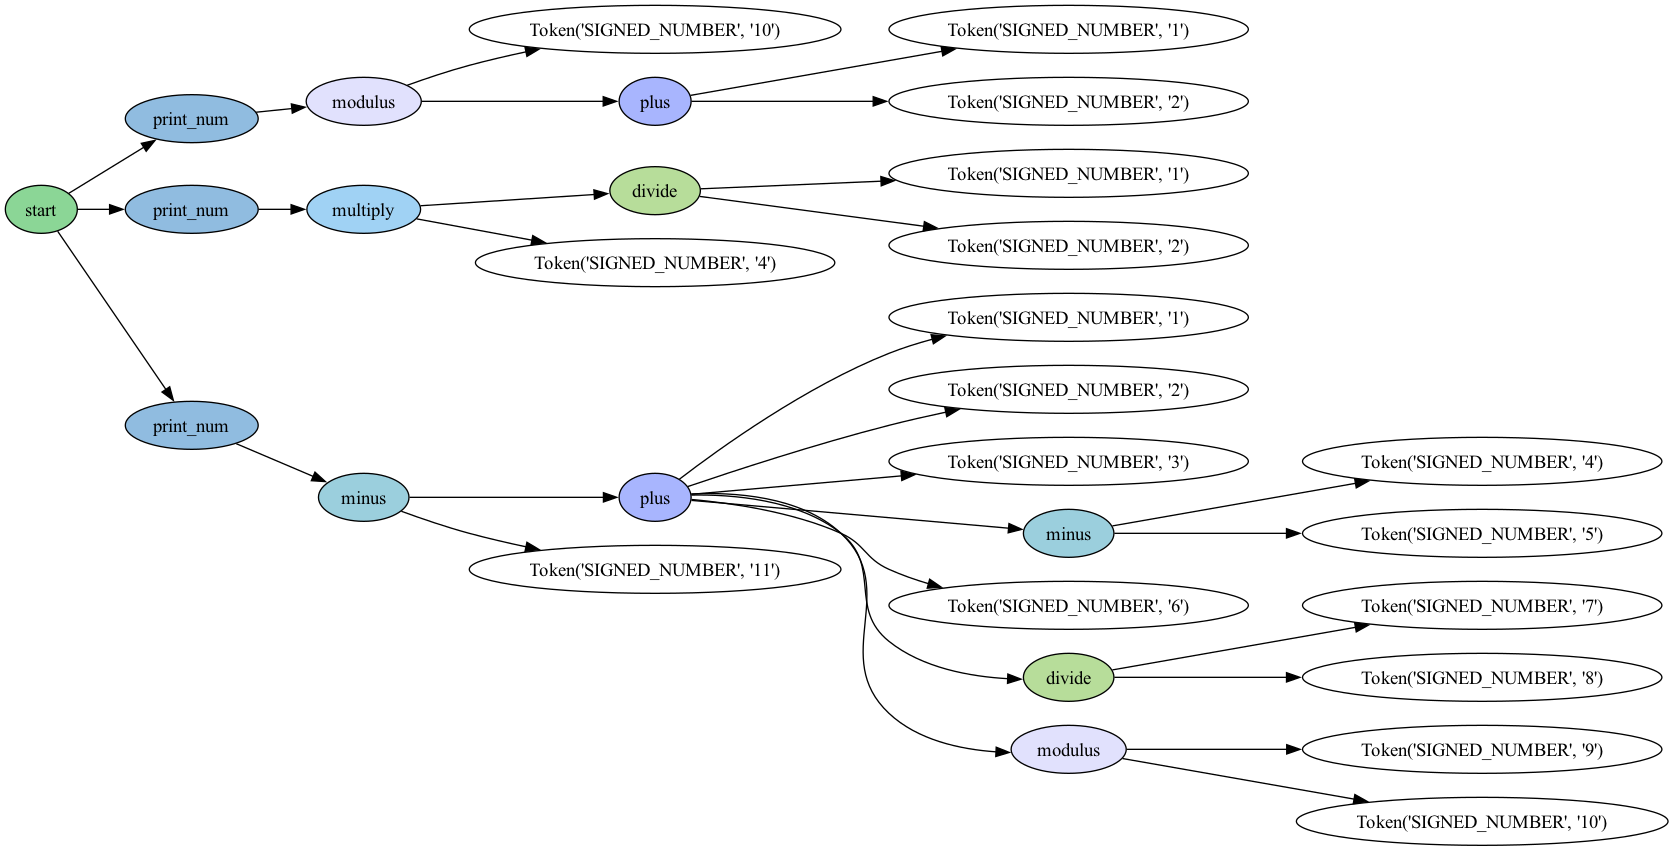

--------------------------------

file: public_test_data/04_1.lsp
--------------------------------
#t
#f
#f
#t
#t
#f
#f
#t


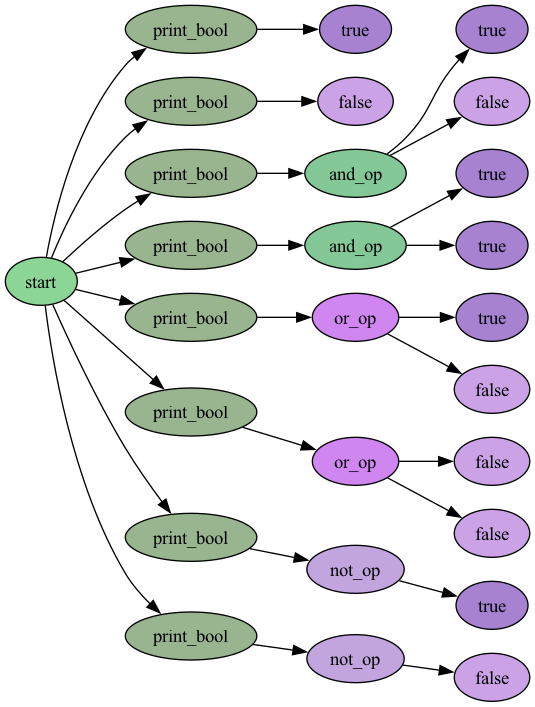

--------------------------------

file: public_test_data/04_2.lsp
--------------------------------
#t
#t
#f


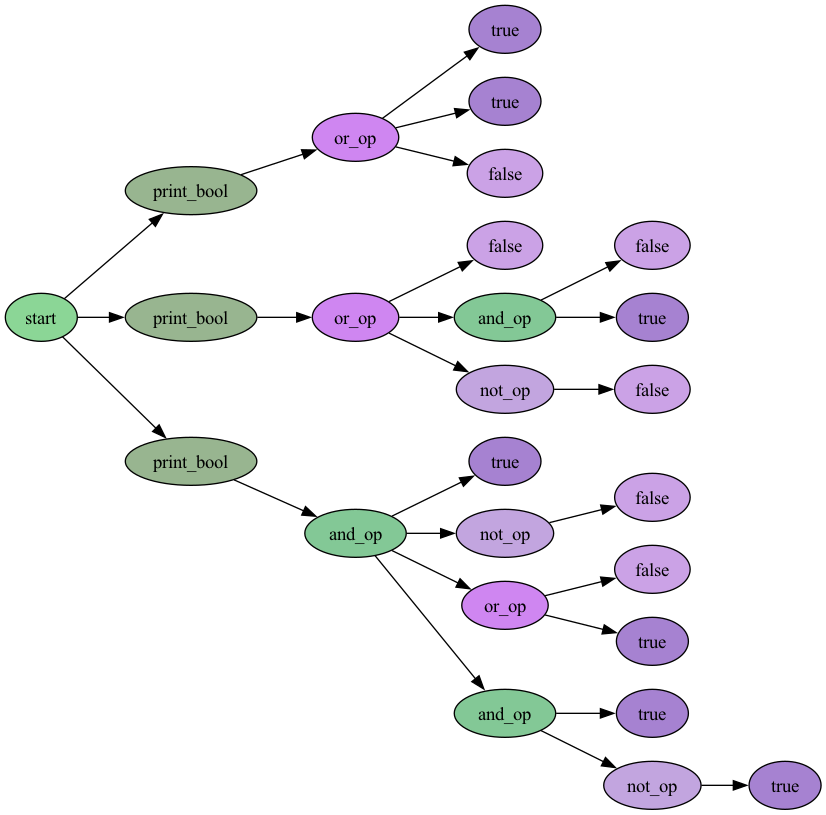

--------------------------------

file: public_test_data/05_1.lsp
--------------------------------
1
2


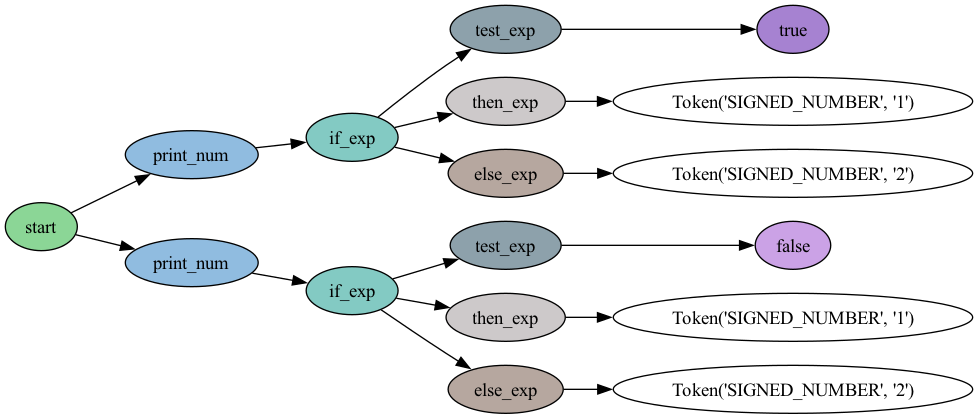

--------------------------------

file: public_test_data/05_2.lsp
--------------------------------
6
1


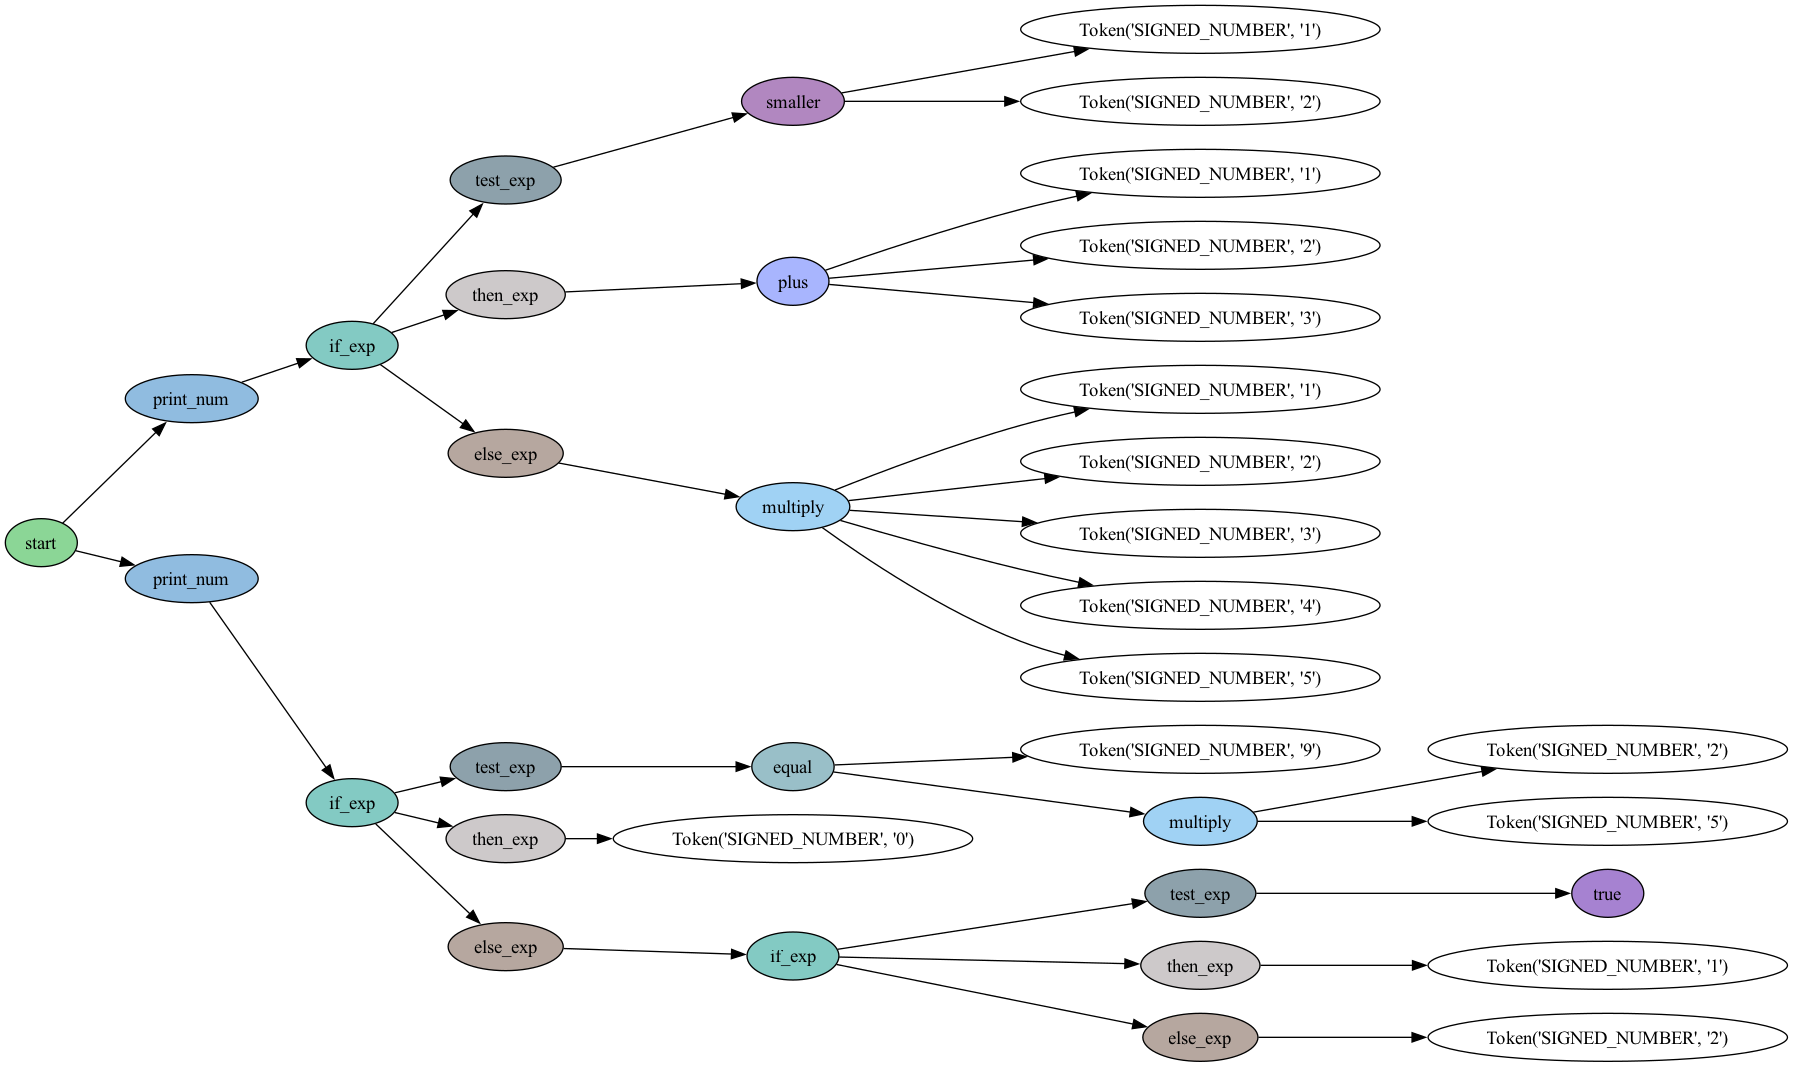

--------------------------------

file: public_test_data/06_1.lsp
--------------------------------
1
6


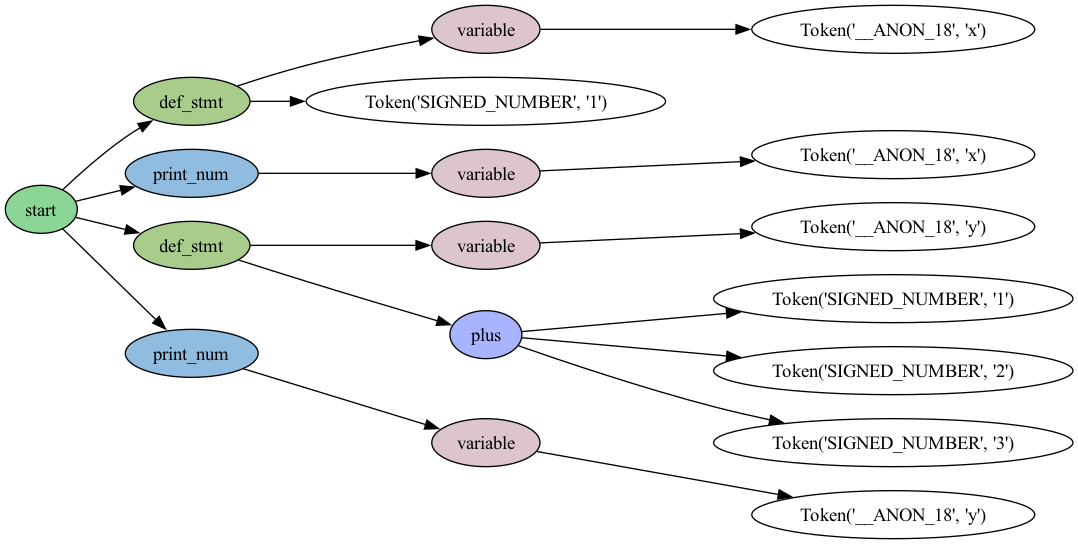

--------------------------------

file: public_test_data/06_2.lsp
--------------------------------
26


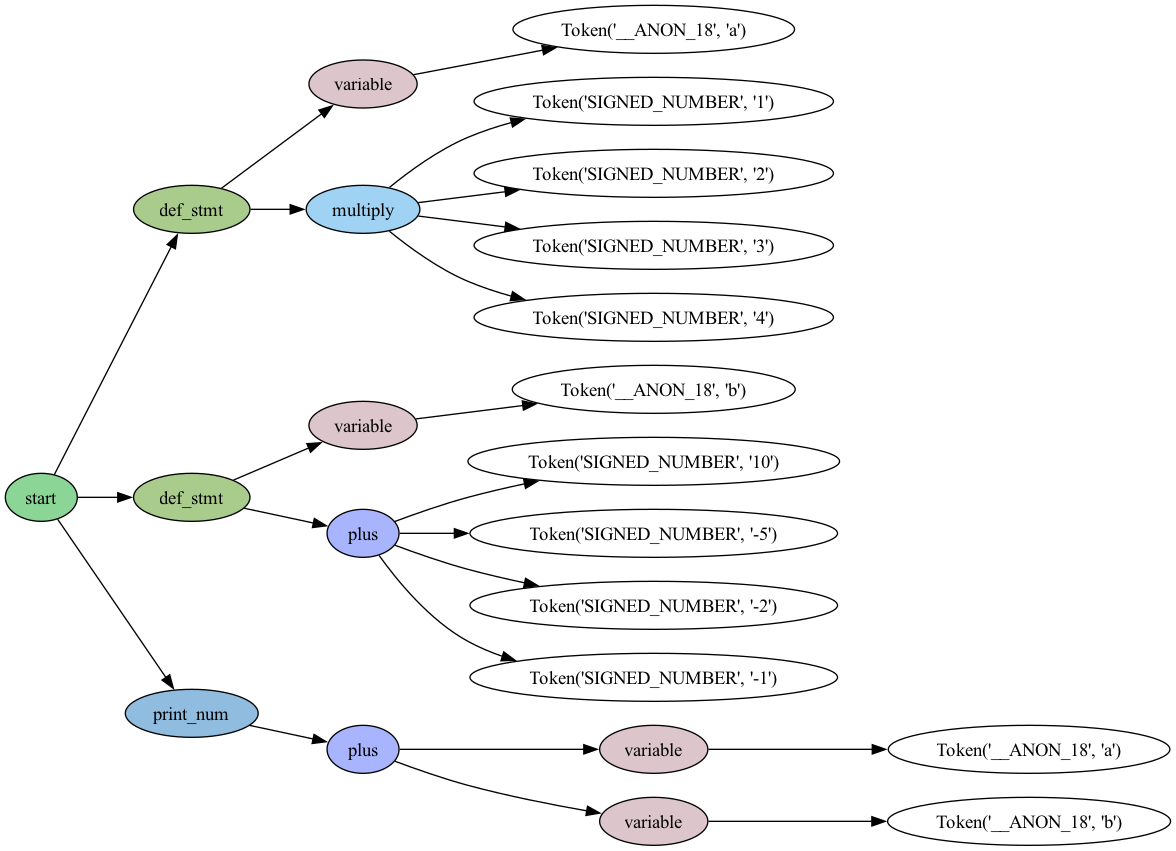

--------------------------------

file: public_test_data/07_1.lsp
--------------------------------
4
9


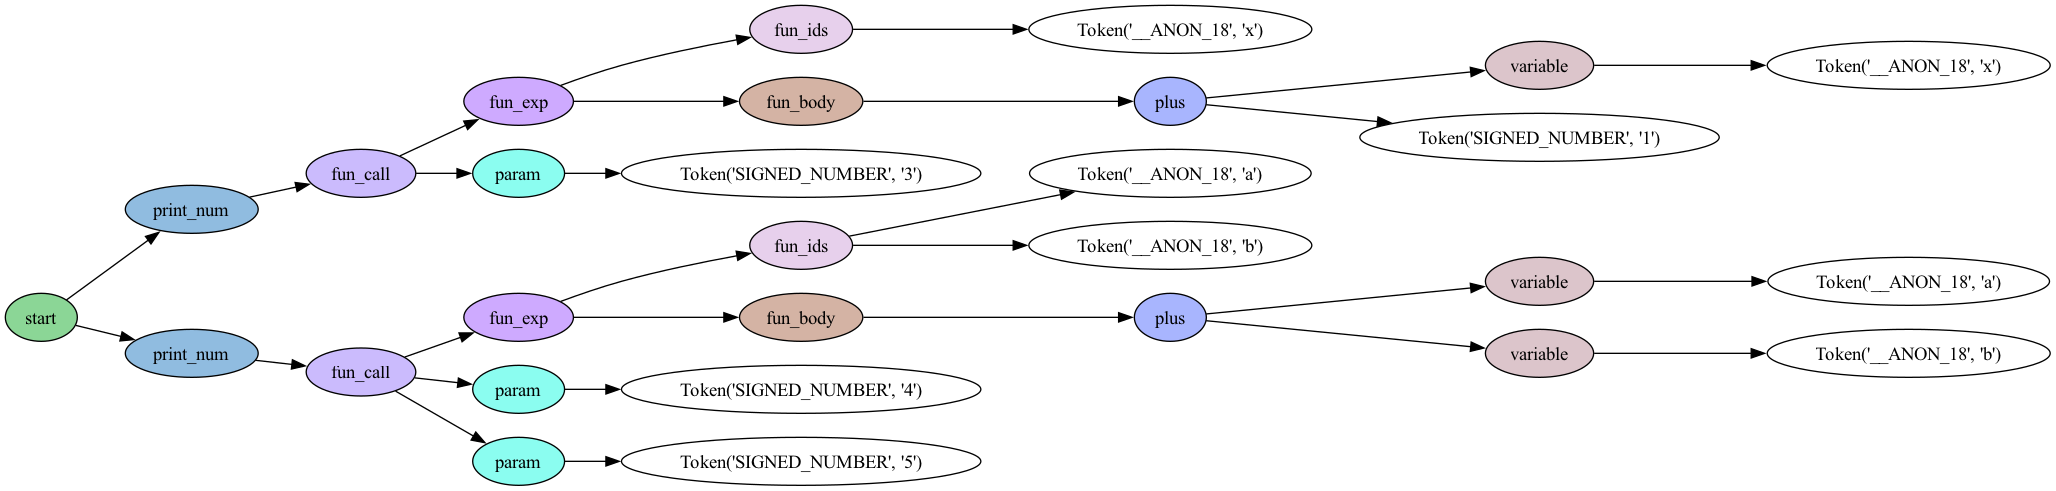

--------------------------------

file: public_test_data/07_2.lsp
--------------------------------
610
0


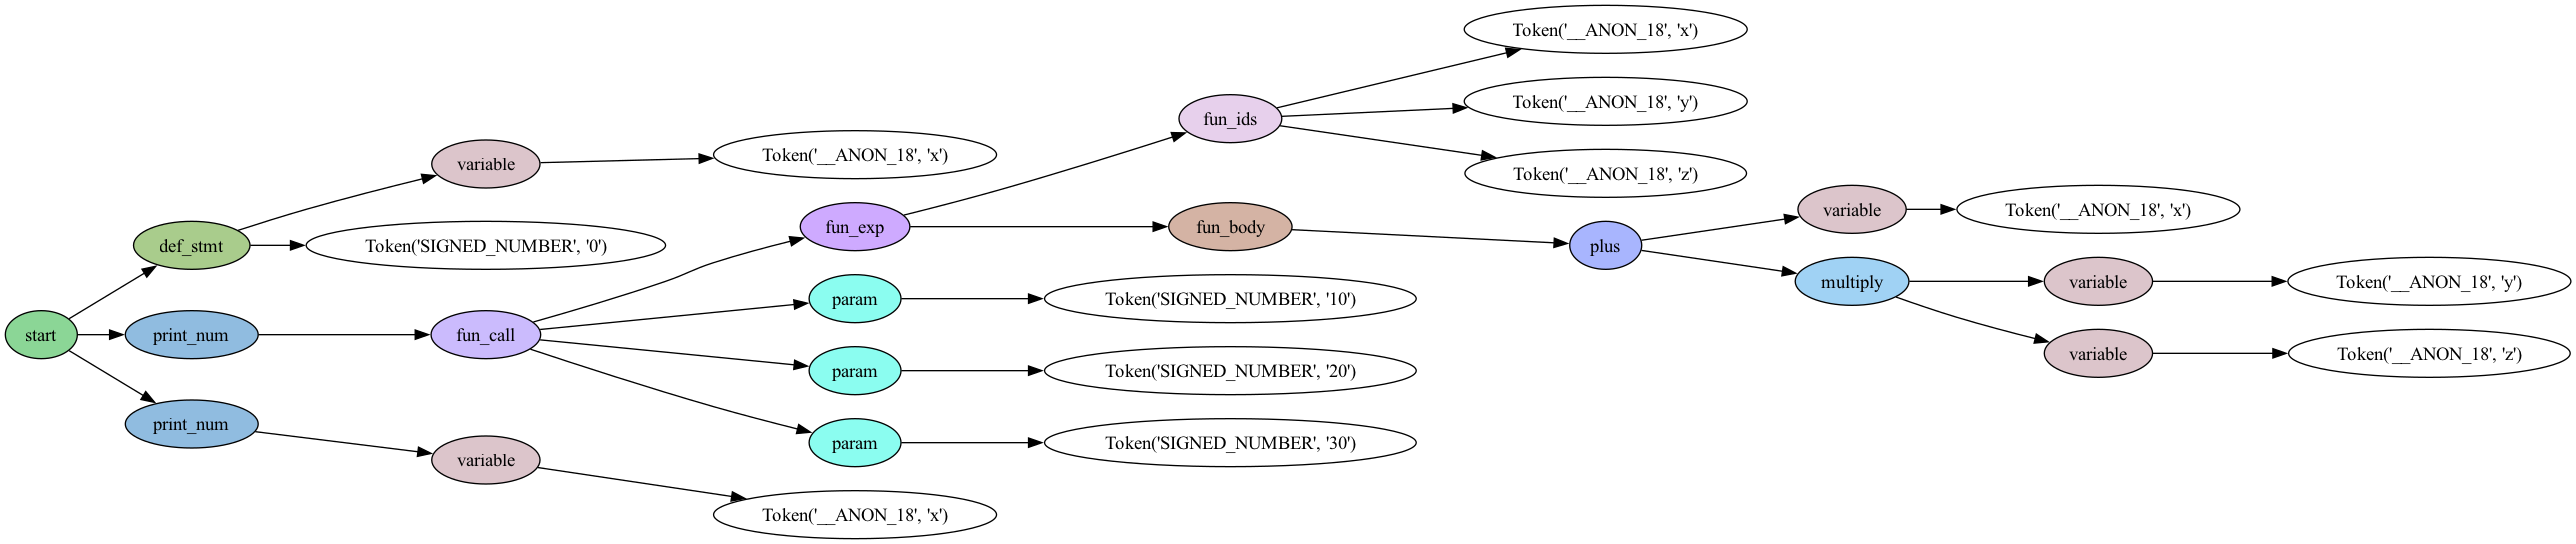

--------------------------------

file: public_test_data/08_1.lsp
--------------------------------
91


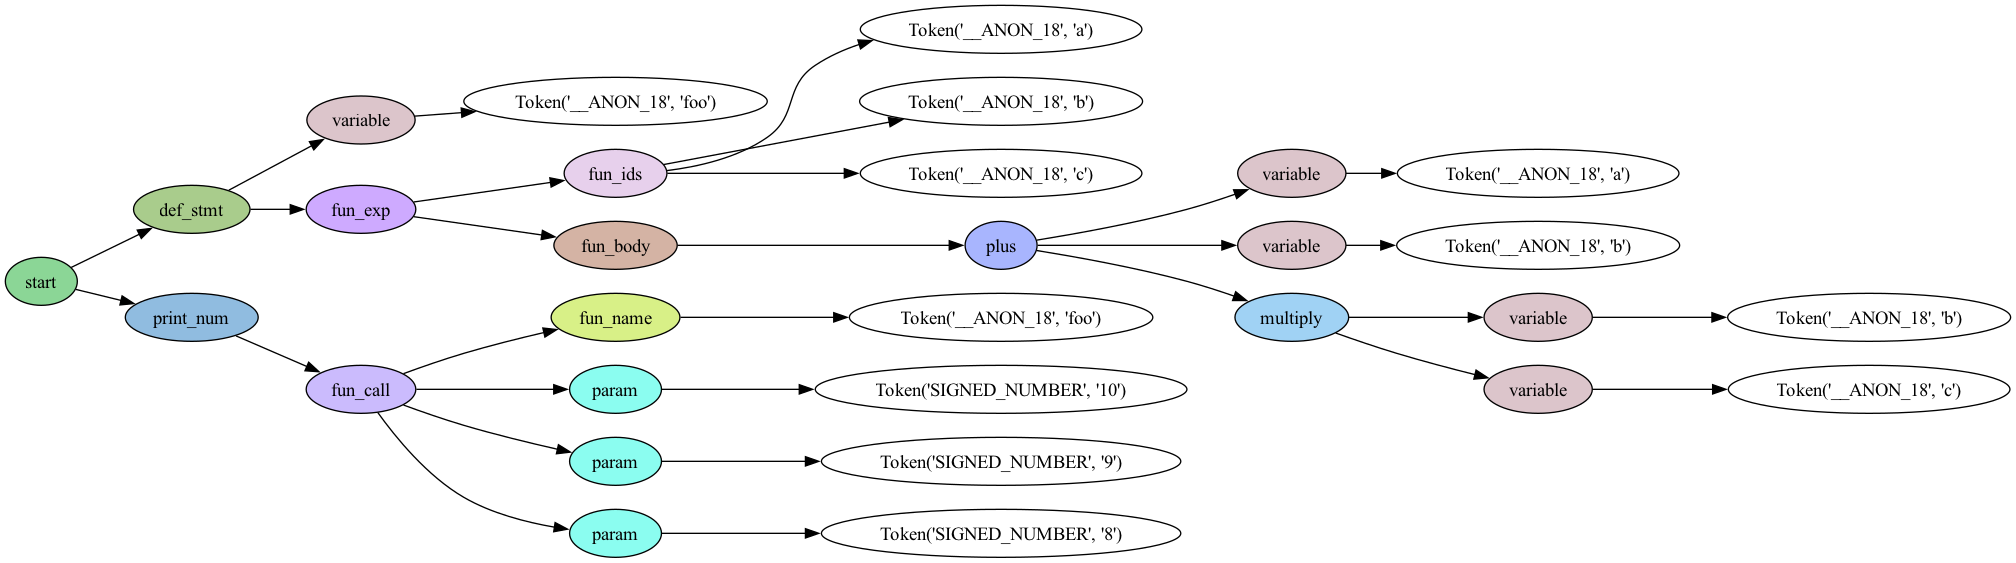

--------------------------------

file: public_test_data/08_2.lsp
--------------------------------
3


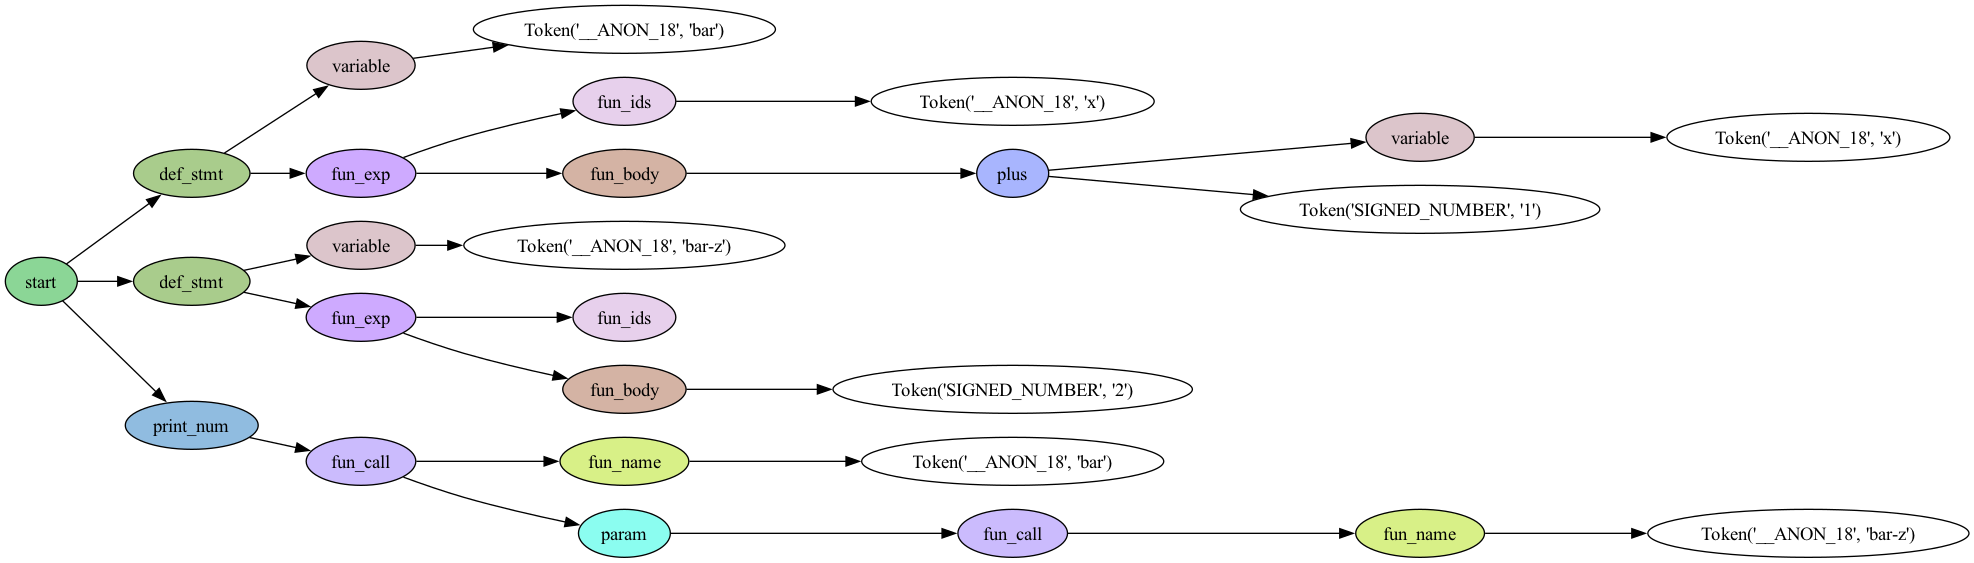

--------------------------------

file: public_test_data/b1_1.lsp
--------------------------------
2
6
24
3628800
1
2
5
55
6765


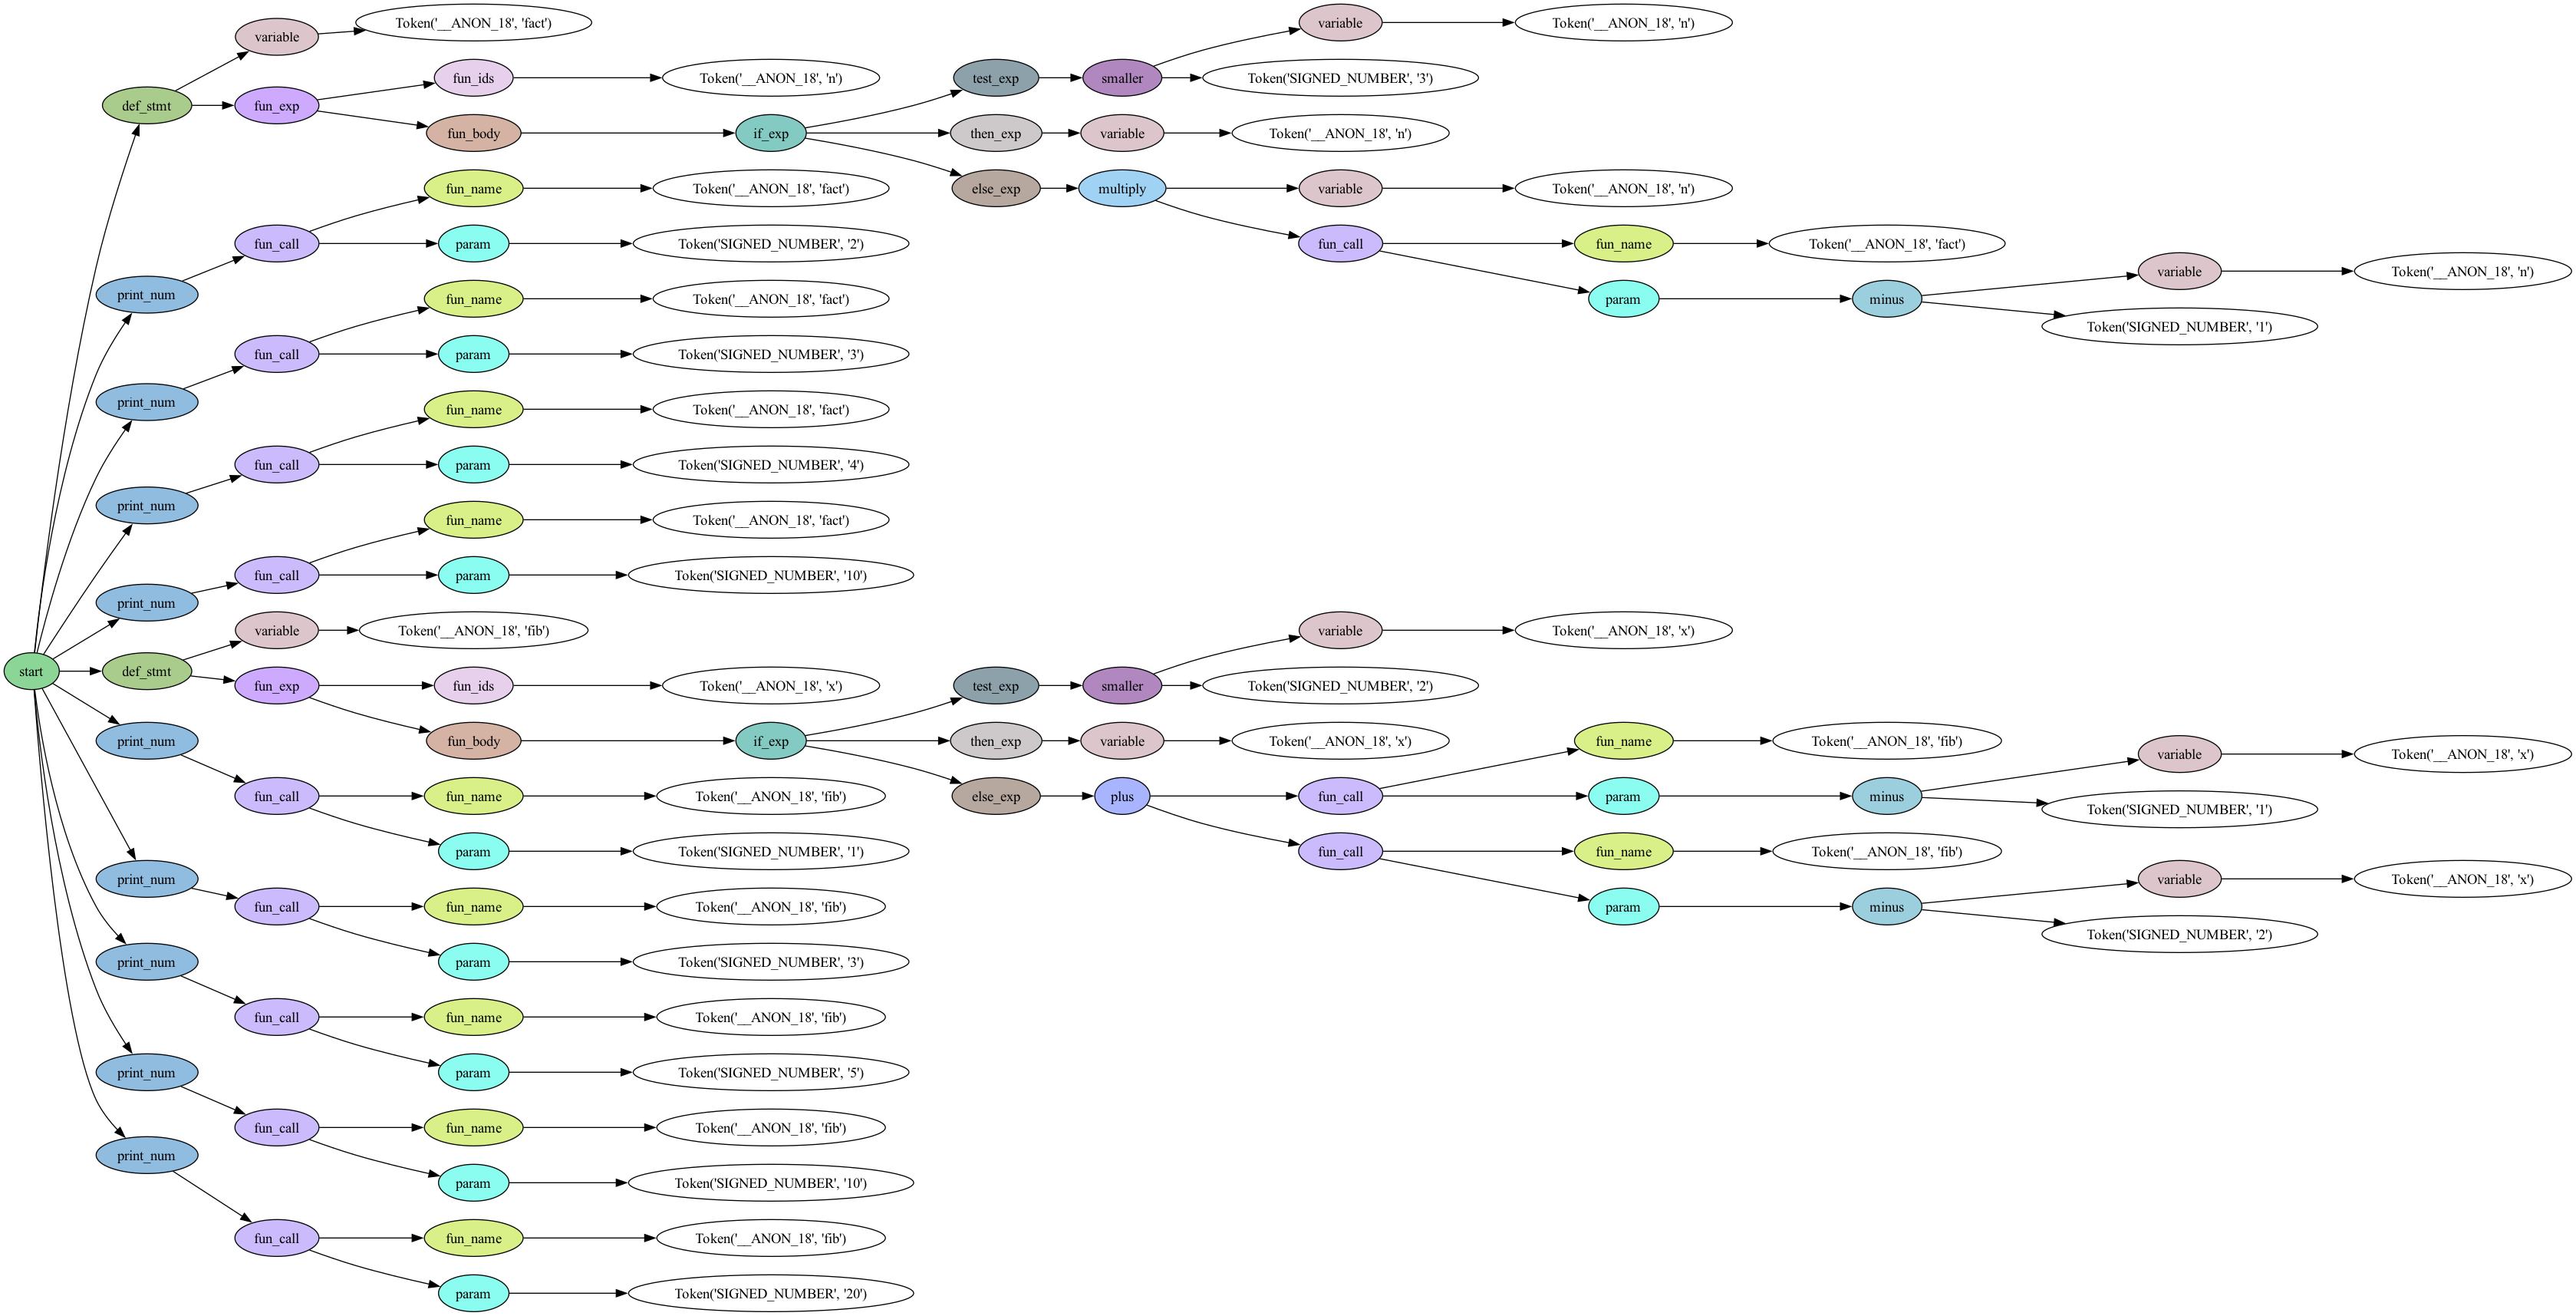

--------------------------------

file: public_test_data/b1_2.lsp
--------------------------------
4
2
27


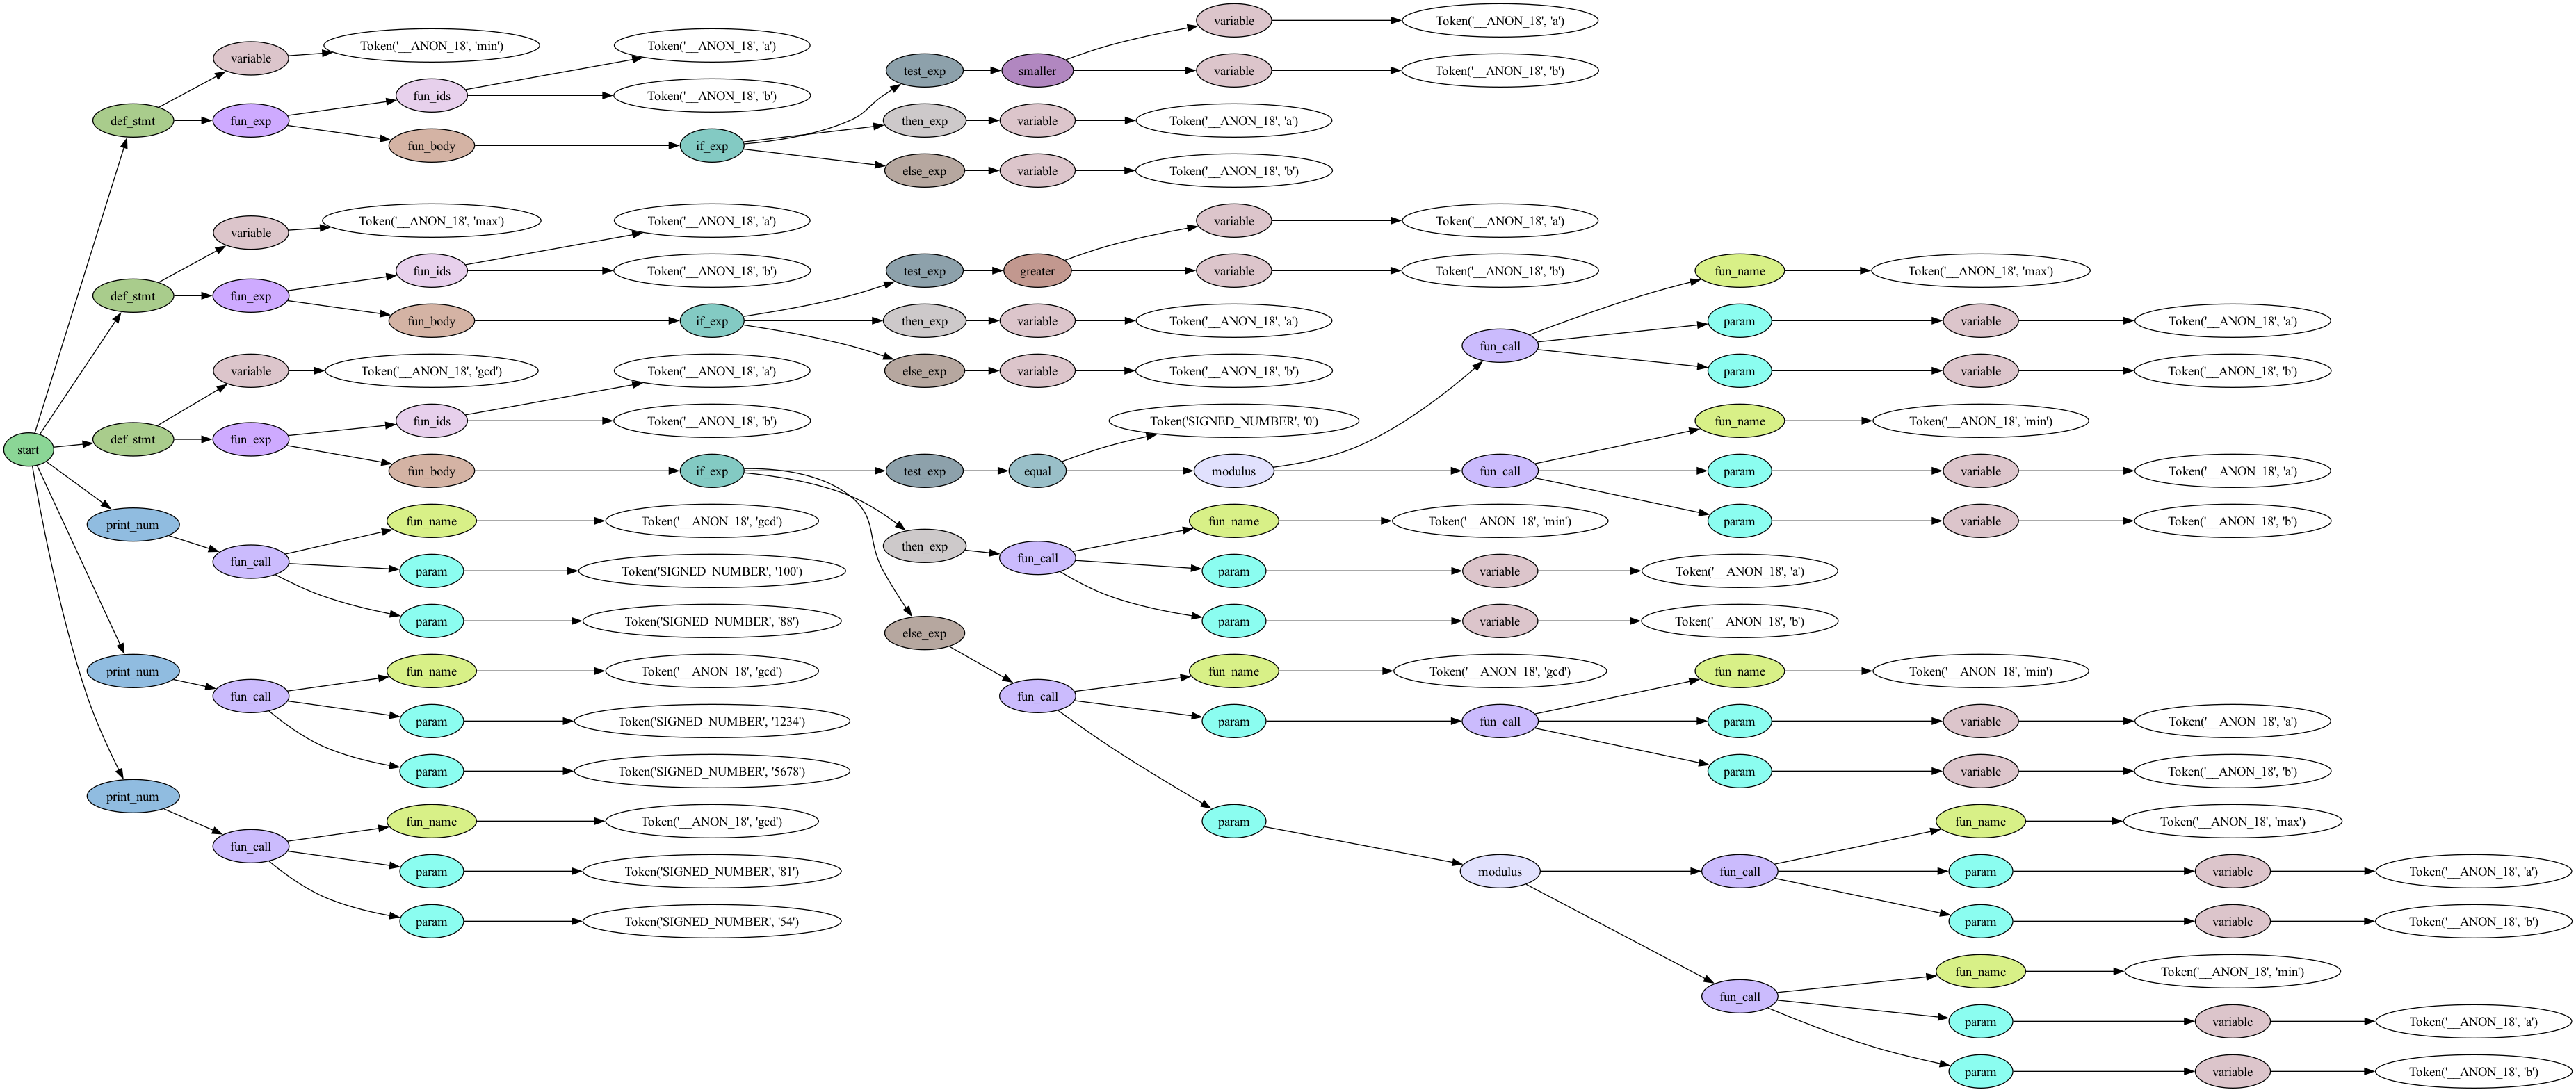

--------------------------------

file: public_test_data/b2_1.lsp
--------------------------------
Type Error
--------------------------------

file: public_test_data/b2_2.lsp
--------------------------------
Type Error
--------------------------------

file: public_test_data/b3_1.lsp
--------------------------------
Syntax Error
--------------------------------

file: public_test_data/b3_2.lsp
--------------------------------
Syntax Error
--------------------------------

file: public_test_data/b4_1.lsp
--------------------------------
Type Error
--------------------------------

file: public_test_data/b4_2.lsp
--------------------------------
Type Error
--------------------------------



In [12]:
test_case_paths = collect_test_case_paths("public_test_data/*.lsp")
for path in test_case_paths:
    run_test_case(path, show_tree=True)